In [1]:
from efficientnet_pytorch import EfficientNet


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from fastai.script import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.distributed import *
from fastprogress import fastprogress
from torchvision.models import *

In [4]:
model = EfficientNet.from_name('efficientnet-b0')

In [5]:
model_name = 'efficientnet-b0'
image_size = EfficientNet.get_image_size(model_name)

In [6]:
image_size

224

In [7]:
model = EfficientNet.from_pretrained(model_name)


Loaded pretrained weights for efficientnet-b0


In [8]:
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [9]:
import pandas as pd


In [10]:
np.random.seed(42)


In [11]:
src = (ImageList.from_folder(path='train-snakes-cropped').split_by_rand_pct(0.2).label_from_folder())

In [12]:
tfms=([rotate(degrees=(-90,90), p=0.8)],[])

In [13]:
bs=96

In [14]:
data = (src.transform(tfms, size=image_size, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=bs).normalize(imagenet_stats))

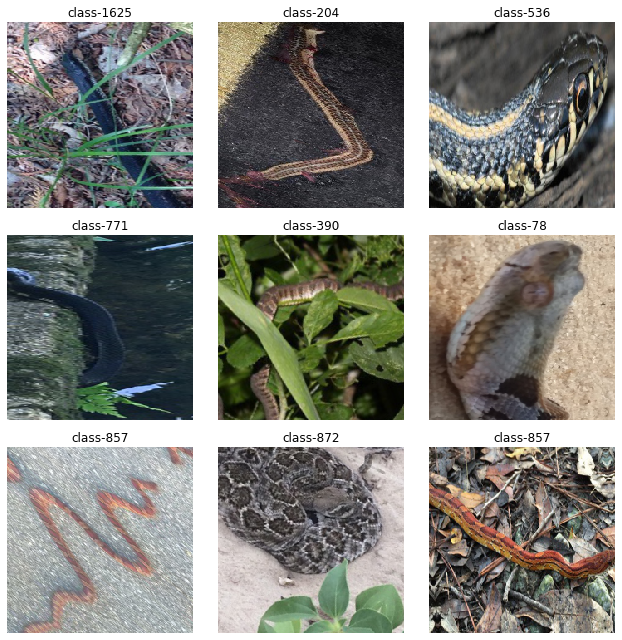

In [15]:
data.show_batch(3,figsize=(9,9))

In [16]:
list(children(model))[-2:]


[BatchNorm2d(1280, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True),
 Linear(in_features=1280, out_features=1000, bias=True)]

In [17]:
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [18]:
ef_head = create_head(1280, data.c, concat_pool=False)
ef_head = nn.Sequential(*(list(ef_head.children())[3:]))

In [19]:
model.add_module('_fc',nn.Linear(1280, data.c))
# model.add_module('_fc',ef_head)

In [20]:
loss_func =LabelSmoothingCrossEntropy()


In [21]:
RMSprop = partial(torch.optim.RMSprop)


In [22]:
from torch.optim import Optimizer

In [23]:
learn = Learner(data, model, loss_func=loss_func, opt_func=RMSprop, metrics=[accuracy,FBeta(beta=1,average='macro')])


In [24]:
learn

Learner(data=ImageDataBunch;

Train: LabelList (65932 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
class-857,class-857,class-857,class-857,class-857
Path: train-snakes-cropped;

Valid: LabelList (16483 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
class-540,class-72,class-771,class-4,class-804
Path: train-snakes-cropped;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_pad

In [25]:
learn.model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [26]:
learn.split([[learn.model._conv_stem, learn.model._bn0, learn.model._blocks[:8]],
             [learn.model._blocks[8:],learn.model._conv_head], 
             [learn.model._bn1,learn.model._fc]])

Learner(data=ImageDataBunch;

Train: LabelList (65932 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
class-857,class-857,class-857,class-857,class-857
Path: train-snakes-cropped;

Valid: LabelList (16483 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
class-540,class-72,class-771,class-4,class-804
Path: train-snakes-cropped;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_pad

In [27]:
learn.summary()

EfficientNet
Layer (type)         Output Shape         Param #    Trainable 
ZeroPad2d            [3, 225, 225]        0          False     
______________________________________________________________________
BatchNorm2d          [32, 112, 112]       64         True      
______________________________________________________________________
ZeroPad2d            [32, 114, 114]       0          False     
______________________________________________________________________
BatchNorm2d          [32, 112, 112]       64         True      
______________________________________________________________________
Identity             [32, 1, 1]           0          False     
______________________________________________________________________
Identity             [8, 1, 1]            0          False     
______________________________________________________________________
Identity             [32, 112, 112]       0          False     
_________________________________________________

In [ ]:
learn.lr_find()


In [ ]:
learn.recorder.plot()

In [28]:
lr=1e-3

In [29]:
learn.fit_one_cycle(40,max_lr=slice(lr/100,lr))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.922494,1.796097,0.624522,0.548774,04:02
1,1.733064,1.650893,0.675180,0.620224,04:03
2,1.620788,1.592844,0.698477,0.645479,04:04
3,1.563509,1.569057,0.712006,0.651194,04:05
4,1.510925,1.564057,0.711036,0.658865,04:05
5,1.455775,1.559955,0.719469,0.665583,04:04
6,1.425873,1.560864,0.721471,0.671084,04:06
7,1.373328,1.497964,0.737123,0.688572,04:03
8,1.331053,1.511876,0.737002,0.684469,04:02
9,1.281772,1.485683,0.740035,0.692029,04:03


In [30]:
learn.save('b0-round-1')

In [31]:
learn.fit_one_cycle(20,max_lr=slice(lr/1000,lr/100))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.743543,1.375028,0.794698,0.757978,04:05
1,0.741115,1.373334,0.794212,0.757709,04:06
2,0.739992,1.375313,0.794576,0.757411,04:06
3,0.742363,1.376345,0.793666,0.755988,04:04


KeyboardInterrupt: 

In [32]:
learn.save('b0-round-2')